# BERT Model

In [1]:
import numpy as np
import wandb
from datasets import load_dataset
from transformers import AutoTokenizer
import tensorflow as tf

c:\Users\asaju\Desktop\Intent-Classification\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("silicone", "maptask")

Found cached dataset silicone (C:/Users/asaju/.cache/huggingface/datasets/silicone/maptask/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5)
100%|██████████| 3/3 [00:00<00:00, 374.69it/s]


In [3]:
# Separate the dataset into train val and test
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

# Separate X (Utterance) and y (Dialogue_Act)
train_X = train_dataset["Utterance"]
train_y = train_dataset["Label"]

val_X = val_dataset["Utterance"]
val_y = val_dataset["Label"]

test_X = test_dataset["Utterance"]
test_y = test_dataset["Label"]

# Convert y from int to one-hot
train_y = tf.keras.utils.to_categorical(train_y)
val_y = tf.keras.utils.to_categorical(val_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFBertModel 

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

# Tokenize the data
train_encodings = tokenizer(train_X, truncation=True, padding=True)
val_encodings = tokenizer(val_X, truncation=True, padding=True)
test_encodings = tokenizer(test_X, truncation=True, padding=True)

# Pad val_encodings and test_encodings to 124
val_encodings['input_ids'] = tf.keras.preprocessing.sequence.pad_sequences(val_encodings['input_ids'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")
val_encodings['attention_mask'] = tf.keras.preprocessing.sequence.pad_sequences(val_encodings['attention_mask'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")

test_encodings['input_ids'] = tf.keras.preprocessing.sequence.pad_sequences(test_encodings['input_ids'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")
test_encodings['attention_mask'] = tf.keras.preprocessing.sequence.pad_sequences(test_encodings['attention_mask'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")

# Convert the data to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_y
))

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
# Fine tune BERT on the Maptask dataset
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(124,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(124,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(256, activation='relu')(out)
out = tf.keras.layers.Dropout(0.2)(out)

y = Dense(12, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = False

optimizer = Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 124)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 124)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

In [6]:
# Train
wandb.init(project="maptask")

# Callbacks
save_model = tf.keras.callbacks.ModelCheckpoint(filepath=wandb.run.dir + '/model.h5', save_best_only=True, monitor='val_loss', mode='min')

batch_size = 256

history = model.fit(
    train_dataset.shuffle(22000).batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    epochs=20,
    batch_size=batch_size,
    callbacks=[save_model, wandb.keras.WandbCallback()]
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexandre-sajus. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
c:\Users\asaju\Desktop\Intent-Classification\venv\lib\site-packages\tensorflow\python\keras\engine\functional.py:592: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Epoch 1/20
82/82 [==============================] - 132s 2s/step - loss: 2.3655 - accuracy: 0.2301 - val_loss: 1.9692 - val_accuracy: 0.3172


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 0.8s


Epoch 2/20
82/82 [==============================] - 122s 1s/step - loss: 2.0151 - accuracy: 0.3455 - val_loss: 1.8376 - val_accuracy: 0.3388


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.1s


Epoch 3/20
82/82 [==============================] - 122s 1s/step - loss: 1.9240 - accuracy: 0.3623 - val_loss: 1.7755 - val_accuracy: 0.3814


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.1s


Epoch 4/20
82/82 [==============================] - 122s 1s/step - loss: 1.8584 - accuracy: 0.3836 - val_loss: 1.7308 - val_accuracy: 0.4033


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.0s


Epoch 5/20
82/82 [==============================] - 122s 1s/step - loss: 1.8198 - accuracy: 0.3908 - val_loss: 1.6992 - val_accuracy: 0.4155


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 0.9s


Epoch 6/20
82/82 [==============================] - 122s 1s/step - loss: 1.7846 - accuracy: 0.4000 - val_loss: 1.6783 - val_accuracy: 0.4225


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.0s


Epoch 7/20
82/82 [==============================] - 122s 1s/step - loss: 1.7638 - accuracy: 0.4105 - val_loss: 1.6641 - val_accuracy: 0.4256


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.1s


Epoch 8/20
82/82 [==============================] - 122s 1s/step - loss: 1.7604 - accuracy: 0.4125 - val_loss: 1.6454 - val_accuracy: 0.4276


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.1s


Epoch 9/20
82/82 [==============================] - 122s 1s/step - loss: 1.7418 - accuracy: 0.4156 - val_loss: 1.6326 - val_accuracy: 0.4303


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.2s


Epoch 10/20
82/82 [==============================] - 122s 1s/step - loss: 1.7281 - accuracy: 0.4254 - val_loss: 1.6227 - val_accuracy: 0.4526


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.8s


Epoch 11/20
82/82 [==============================] - 122s 1s/step - loss: 1.7303 - accuracy: 0.4224 - val_loss: 1.6130 - val_accuracy: 0.4735


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.3s


Epoch 12/20
82/82 [==============================] - 122s 1s/step - loss: 1.7108 - accuracy: 0.4383 - val_loss: 1.6059 - val_accuracy: 0.4752


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.5s


Epoch 13/20
82/82 [==============================] - 122s 1s/step - loss: 1.6885 - accuracy: 0.4461 - val_loss: 1.5996 - val_accuracy: 0.4782


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.4s


Epoch 14/20
82/82 [==============================] - 122s 1s/step - loss: 1.7016 - accuracy: 0.4285 - val_loss: 1.5916 - val_accuracy: 0.4789


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.5s


Epoch 15/20
82/82 [==============================] - 122s 1s/step - loss: 1.6803 - accuracy: 0.4366 - val_loss: 1.5856 - val_accuracy: 0.4813


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.4s


Epoch 16/20
82/82 [==============================] - 122s 1s/step - loss: 1.6925 - accuracy: 0.4327 - val_loss: 1.5799 - val_accuracy: 0.4836


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.5s


Epoch 17/20
82/82 [==============================] - 122s 1s/step - loss: 1.6715 - accuracy: 0.4473 - val_loss: 1.5752 - val_accuracy: 0.4840


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.5s


Epoch 18/20
82/82 [==============================] - 122s 1s/step - loss: 1.6651 - accuracy: 0.4464 - val_loss: 1.5709 - val_accuracy: 0.4833


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.5s


Epoch 19/20
82/82 [==============================] - 122s 1s/step - loss: 1.6656 - accuracy: 0.4442 - val_loss: 1.5665 - val_accuracy: 0.4846


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.5s


Epoch 20/20
82/82 [==============================] - 122s 1s/step - loss: 1.6628 - accuracy: 0.4470 - val_loss: 1.5622 - val_accuracy: 0.4853


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\Intent-Classification\wandb\run-20230404_123926-t09hu3r4\files\model-best)... Done. 1.6s


In [7]:
# Evaluate
model.evaluate(test_dataset.batch(batch_size))

c:\Users\asaju\Desktop\Intent-Classification\venv\lib\site-packages\tensorflow\python\keras\engine\functional.py:592: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


12/12 [==============================] - 16s 1s/step - loss: 1.5824 - accuracy: 0.4972


[1.5824215412139893, 0.49723565578460693]

c:\Users\asaju\Desktop\Intent-Classification\venv\lib\site-packages\tensorflow\python\keras\engine\functional.py:592: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


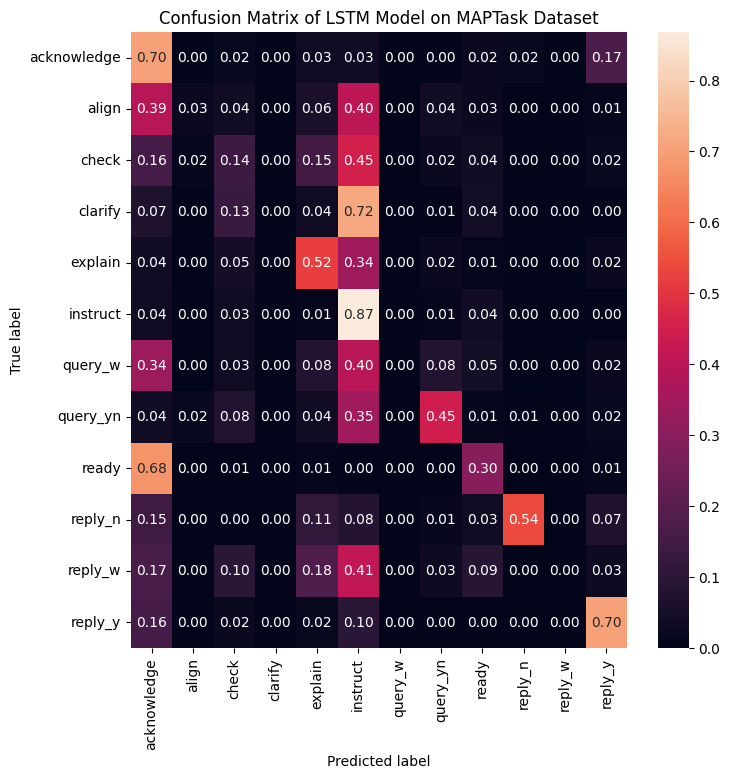

In [8]:
# Plot the confusion matrix of the 12 labels
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_dataset.batch(batch_size))
y_pred = np.argmax(y_pred, axis=1)
y_test_plot = np.argmax(test_y, axis=1)

cm = confusion_matrix(y_test_plot, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
plt.title('Confusion Matrix of LSTM Model on MAPTask Dataset')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=dataset["train"].features["Label"].names, yticklabels=dataset["train"].features["Label"].names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
